In [216]:
import json

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy.spatial as sp

In [217]:
dataset_path = "../datasets/UrbanVehicle"

# Create road graph as networkx DiGraph
road_graph = nx.DiGraph()
with open(f"{dataset_path}/map.json", mode="r", encoding="utf-8") as file:
    items = json.load(file)

    for item in items:
        if item["type"] == "node":
            road_graph.add_node(item["id"], pos=(item["xy"][0], item["xy"][1]))

    edge_id = 0
    for item in items:
        if item["type"] == "way":
            nodes = item["nodes"]
            is_oneway = item["oneway"]

            for u, v in zip(nodes, nodes[1:]):
                road_graph.add_edge(u, v, id=edge_id)
                edge_id += 1
                if not is_oneway:
                    road_graph.add_edge(v, u, id=edge_id)
                    edge_id += 1

# Remove self-loops
# Nodes with self-loops: 64, 74, 192, 193, 198, 255, 262, 272, 277, 442, 448, 505, 595, 653, 829, 872, 1035, 1052, 1054, 1055, 1150
road_graph.remove_edges_from(nx.selfloop_edges(road_graph))

print(road_graph)

# Check connectivity
# Non-connected nodes: 2336, 6817, 2341, 2247, 1512, 2248, 5289, 2795, 2796, 1520, 7857, 2262, 7448, 2333
# Non-connected edges: 9344, 10424
print("Road graph is strongly connected: ", nx.is_strongly_connected(road_graph))
print("Road graph is weakly connected: ", nx.is_weakly_connected(road_graph))

DiGraph with 8270 nodes and 10186 edges
Road graph is strongly connected:  False
Road graph is weakly connected:  False


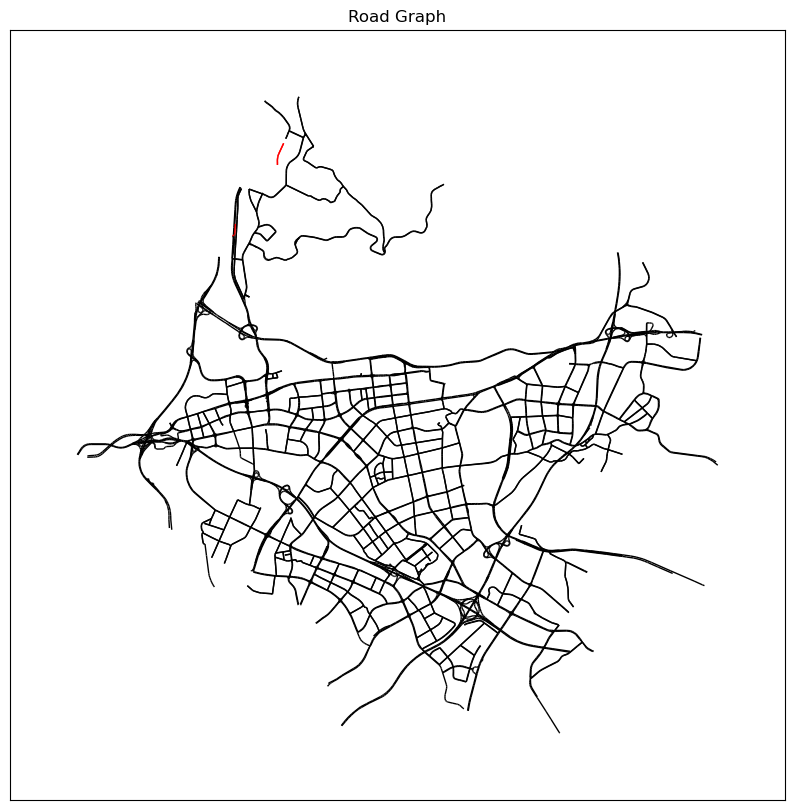

In [218]:
# Find maximum weakly-connected subgraph
wccs = list(nx.weakly_connected_components(road_graph))
largest_wcc = max(wccs, key=len)
largest_wcc_sub_road_graph = road_graph.subgraph(largest_wcc).copy()

# Draw the road graph
pos = nx.get_node_attributes(road_graph, "pos")

left_out_nodes = set(road_graph.nodes()) - set(largest_wcc_sub_road_graph.nodes())
left_out_sub_road_graph = road_graph.subgraph(left_out_nodes)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# nx.draw_networkx(
#     road_graph,
#     pos,
#     with_labels=False,
#     arrows=False,
#     node_size=1,
#     ax=ax
# )
# nx.draw_networkx_nodes(
#     largest_wcc_sub_road_graph,
#     pos,
#     node_size=1,
#     ax=ax
# )
# nx.draw_networkx_nodes(
#     left_out_sub_road_graph,
#     pos,
#     node_color="red",
#     node_size=10,
#     ax=ax
# )
nx.draw_networkx_edges(
    largest_wcc_sub_road_graph,
    pos,
    arrows=False,
    ax=ax
)
nx.draw_networkx_edges(
    left_out_sub_road_graph,
    pos,
    edge_color="red",
    arrows=False,
    ax=ax
)
ax.set_title("Road Graph")

plt.show()

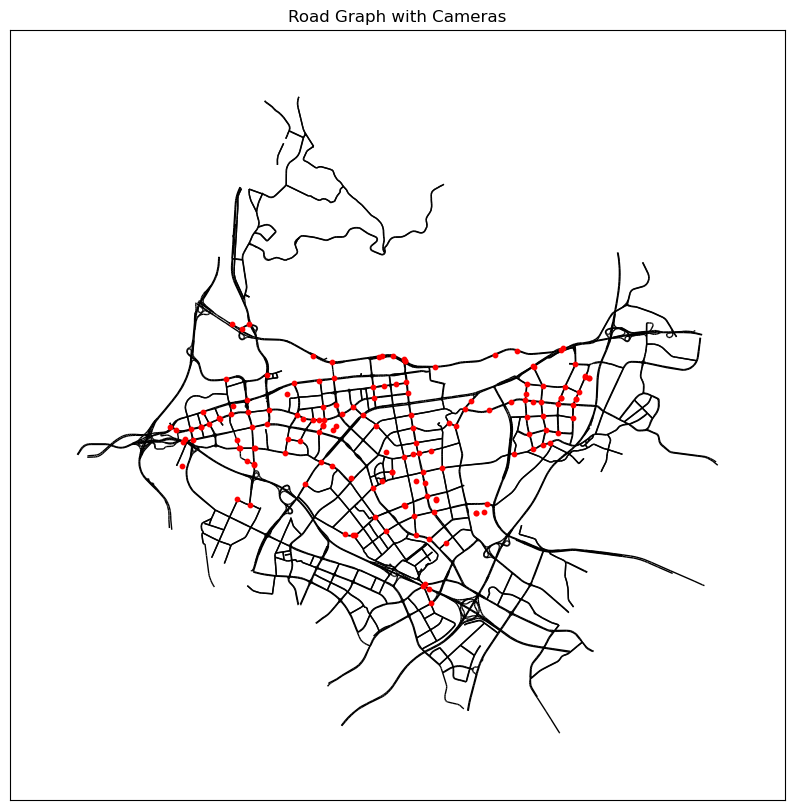

In [219]:
# Load cameras
cameras = list()
with open(f"{dataset_path}/cameras.json", mode="r", encoding="utf-8") as file:
    for line in file:
        camera = json.loads(line)
        cameras.append((camera["camera_id"], camera['position'][0], camera['position'][1]))

# Find each camera's nearest node
nodes = list(road_graph.nodes(data=True))
node_coordinates = np.array([[node[1]["pos"][0], node[1]["pos"][1]] for node in nodes])
camera_coordinates = np.array([[camera[1], camera[2]] for camera in cameras])
tree = sp.KDTree(node_coordinates)
d, i = tree.query(camera_coordinates, k=1)

# Draw cameras on road graph
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

nx.draw_networkx_edges(
    road_graph,
    pos,
    arrows=False,
    ax=ax
)

ax.scatter(camera_coordinates[:, 0], camera_coordinates[:, 1], s=10, c="red")
ax.set_title("Road Graph with Cameras")

plt.show()